In [52]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
from IPython.display import clear_output
import time

from scipy.ndimage import rotate
from scipy.interpolate import RegularGridInterpolator
import h5py
import os
from pathlib import Path

from matplotlib.patches import Circle
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d

In [42]:
def polarization_est(file_array):
    folder_names=file_array
    l=len(file_array)
    px=67
    psf_scale=0.0208 # arcsecs/pixel
    Q_lin_list=[]
    I_lin_list=[]
    p_lin_list=[]
    
    figr=[]

    for i in range (l):
        
        f_dir=folder_names[i]
        I_flux=fits.getdata(f_dir+'I_flux_band.fits')
        Q_flux=fits.getdata(f_dir+'Q_flux_band.fits')
        U_flux=fits.getdata(f_dir+'U_flux_band.fits')
        p_r=fits.getdata(f_dir+'pout_band.fits')
        
        xarc=(np.arange (-px+33, px-34, 1))*psf_scale
        yarc=(np.arange (-px+33, px-34, 1))*psf_scale
        
        np.seterr(invalid='ignore')
        sq_as_per_pix=psf_scale**2
        

        I_flux[np.isnan(I_flux)]=0
        Q_flux[np.isnan(Q_flux)]=0
        U_flux[np.isnan(U_flux)]=0
        p_r[np.isnan(p_r)]=0
        
        y, x = np.indices(Q_flux.shape)     # 0.0665AU/pixel
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
        qx, qy=np.unravel_index(np.argmax(Q_flux), Q_flux.shape)
        ix, iy=np.unravel_index(np.argmax(I_flux), I_flux.shape)
        prx, pry =np.unravel_index(np.argmax(p_r), p_r.shape)
        
        npix=2
        
        Q_flux_lin=np.mean(Q_flux[qx-npix:qx+npix,:],axis=0)
        I_flux_lin=np.mean(I_flux[qx-npix:qx+npix,:],axis=0)
        p_r_lin   =np.mean(p_r[qx-npix:qx+npix,:],axis=0)
        
        Q_lin_list.append(Q_flux_lin)
        I_lin_list.append(I_flux_lin)
        p_lin_list.append(p_r_lin)
        
        
        fig = plt.figure(figsize=(25, 12))


        ax1=fig.add_subplot(141)
        ax1.yaxis.set_ticks_position('both')
        ax1.xaxis.set_ticks_position('both')
        ax1.minorticks_on()
        ax1.tick_params(which='both', direction='in', width=0.5, labelsize=16)
        im1=ax1.imshow(Q_flux,cmap='plasma',extent=[np.min(yarc),np.max(yarc),np.min(xarc),np.max(xarc)])
        ax1.invert_yaxis()
        ax1.set_ylabel('arcsecs',fontsize=18)
        ax1.set_xlabel('arcsecs',fontsize=18)
        ax1.set_title(r'$Q_{\phi}$',fontsize=18)
        cb = fig.colorbar(im1,orientation='vertical',shrink=0.35)
        cb.set_label('mjy/arcsec2',fontsize=18)
        cb.ax.tick_params(labelsize=18)
        ax1.grid(False)

        ax2=fig.add_subplot(142)
        ax2.yaxis.set_ticks_position('both')
        ax2.xaxis.set_ticks_position('both')
        ax2.minorticks_on()
        ax2.tick_params(which='both', direction='in', width=0.5, labelsize=16)
        im2=ax2.imshow(U_flux,cmap='plasma',extent=[np.min(yarc),np.max(yarc),np.min(xarc),np.max(xarc)])
        ax2.invert_yaxis()
        ax2.set_ylabel('arcsecs',fontsize=18)
        ax2.set_xlabel('arcsecs',fontsize=18)
        ax2.set_title(r'$U$',fontsize=18)
        cb = fig.colorbar(im2,orientation='vertical',shrink=0.35)
        cb.set_label('mjy/arcsec2',fontsize=18)
        cb.ax.tick_params(labelsize=18)
        ax2.grid(False)
        
        ax2=fig.add_subplot(143)
        ax2.yaxis.set_ticks_position('both')
        ax2.xaxis.set_ticks_position('both')
        ax2.minorticks_on()
        ax2.tick_params(which='both', direction='in', width=0.5, labelsize=16)
        im2=ax2.imshow(p_r,cmap='plasma',extent=[np.min(yarc),np.max(yarc),np.min(xarc),np.max(xarc)])
        ax2.invert_yaxis()
        ax2.set_ylabel('arcsecs',fontsize=18)
        ax2.set_xlabel('arcsecs',fontsize=18)
        ax2.set_title('$p$',fontsize=18)
        cb = fig.colorbar(im2,orientation='vertical',shrink=0.35)
        cb.set_label('p',fontsize=18)
        cb.ax.tick_params(labelsize=18)
        ax2.grid(False)

        ax2=fig.add_subplot(144)
        ax2.yaxis.set_ticks_position('both')
        ax2.xaxis.set_ticks_position('both')
        ax2.minorticks_on()
        ax2.tick_params(which='both', direction='in', width=0.5, labelsize=16)
        im2=ax2.imshow(I_flux,cmap='plasma',extent=[np.min(yarc),np.max(yarc),np.min(xarc),np.max(xarc)])
        ax2.invert_yaxis()
        ax2.set_ylabel('arcsecs',fontsize=18)
        ax2.set_xlabel('arcsecs',fontsize=18)
        ax2.set_title('I',fontsize=18)
        cb = fig.colorbar(im2,orientation='vertical',shrink=0.35)
        cb.set_label('mjy/arcsec2',fontsize=18)
        cb.ax.tick_params(labelsize=18)
        ax2.grid(False)

        
        fig.subplots_adjust(hspace=0.2, wspace=0.6, top=1, right=0.95)
        
        #fig_path=f_dir+'polarization_output'+'.pdf'
        #fig.savefig(fig_path, format='pdf', bbox_inches='tight')
        figr.append(fig)
    return(Q_lin_list,I_lin_list, p_lin_list)

In [43]:
def polarization_plot(file_array):
    folder_names=file_array
    l=len(file_array)
    px=67
    psf_scale=0.0208 # arcsecs/pixel
    p_r_list=[]
    
    figr=[]

    for i in range (l):
        
        f_dir=folder_names[i]
        p_r=fits.getdata(f_dir+'pout_band.fits')
        
        xarc=(np.arange (-px+33, px-34, 1))*psf_scale
        yarc=(np.arange (-px+33, px-34, 1))*psf_scale
        
        np.seterr(invalid='ignore')
        sq_as_per_pix=psf_scale**2
        p_r[np.isnan(p_r)]=0
        
        p_r_list.append(p_r)
        
        
    fig = plt.figure(figsize=(30, 5))

    ax1=plt.subplot2grid((1,5),(0,0))
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.minorticks_on()
    ax1.tick_params(which='both', direction='in', width=0.5, labelsize=16)
    im1=ax1.imshow(p_r_list[0],cmap='magma',extent=[np.min(yarc),np.max(yarc),np.min(xarc),np.max(xarc)])
    ax1.invert_yaxis()
    ax1.set_ylabel('arcsecs',fontsize=18)
    ax1.set_xlabel('arcsecs',fontsize=18)
    ax1.set_title('Astrosilicates',fontsize=18)
    cb = fig.colorbar(im1,orientation='vertical',shrink=0.5)
    cb.set_label('p',fontsize=18)
    cb.ax.tick_params(labelsize=18)
    ax1.grid(False)

    ax1=plt.subplot2grid((1,5),(0,1))
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.minorticks_on()
    ax1.tick_params(which='both', direction='in', width=0.5, labelsize=16)
    im1=ax1.imshow(p_r_list[1],cmap='magma',extent=[np.min(yarc),np.max(yarc),np.min(xarc),np.max(xarc)])
    ax1.invert_yaxis()
    ax1.set_ylabel('arcsecs',fontsize=18)
    ax1.set_xlabel('arcsecs',fontsize=18)
    ax1.set_title('Olivines',fontsize=18)
    cb = fig.colorbar(im1,orientation='vertical',shrink=0.5)
    cb.set_label('p',fontsize=18)
    cb.ax.tick_params(labelsize=18)
    ax1.grid(False)
    
    ax1=plt.subplot2grid((1,5),(0,2))
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.minorticks_on()
    ax1.tick_params(which='both', direction='in', width=0.5, labelsize=16)
    im1=ax1.imshow(p_r_list[2],cmap='magma',extent=[np.min(yarc),np.max(yarc),np.min(xarc),np.max(xarc)])
    ax1.invert_yaxis()
    ax1.set_ylabel('arcsecs',fontsize=18)
    ax1.set_xlabel('arcsecs',fontsize=18)
    ax1.set_title('Astrosil+Olivines',fontsize=18)
    cb = fig.colorbar(im1,orientation='vertical',shrink=0.5)
    cb.set_label('p',fontsize=18)
    cb.ax.tick_params(labelsize=18)
    ax1.grid(False)
    
    ax1=plt.subplot2grid((1,5),(0,3))
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.minorticks_on()
    ax1.tick_params(which='both', direction='in', width=0.5, labelsize=16)
    im1=ax1.imshow(p_r_list[3],cmap='magma',extent=[np.min(yarc),np.max(yarc),np.min(xarc),np.max(xarc)])
    ax1.invert_yaxis()
    ax1.set_ylabel('arcsecs',fontsize=18)
    ax1.set_xlabel('arcsecs',fontsize=18)
    ax1.set_title('Carbon',fontsize=18)
    cb = fig.colorbar(im1,orientation='vertical',shrink=0.5)
    cb.set_label('p',fontsize=18)
    cb.ax.tick_params(labelsize=18)
    ax1.grid(False)
    
    ax1=plt.subplot2grid((1,5),(0,4))
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.minorticks_on()
    ax1.tick_params(which='both', direction='in', width=0.5, labelsize=16)
    im1=ax1.imshow(p_r_list[4],cmap='magma',extent=[np.min(yarc),np.max(yarc),np.min(xarc),np.max(xarc)])
    ax1.invert_yaxis()
    ax1.set_ylabel('arcsecs',fontsize=18)
    ax1.set_xlabel('arcsecs',fontsize=18)
    ax1.set_title('Graphite',fontsize=18)
    cb = fig.colorbar(im1,orientation='vertical',shrink=0.5)
    cb.set_label('p',fontsize=18)
    cb.ax.tick_params(labelsize=18)
    ax1.grid(False)
    fig.subplots_adjust(hspace=0.2, wspace=0.5, top=1, right=0.95)
    
    #fig_dir='/Users/polaris/Onedrive-UA/OneDrive - University of Arizona/Debris-Disk-Modelling/Debris-Disk-Modelling/Eps-eri-Roman_pol/Simulations_paper/HLC_band/'
    fig_path=f_dir+'polarization_fraction_dust'+'.pdf'
    fig.savefig(fig_path, format='pdf', bbox_inches='tight')
    
    return(figr)

In [44]:
Main_dir='/Users/polaris/Onedrive-UA/OneDrive - University of Arizona/Debris-Disk-Modelling/Debris-Disk-Modelling/Eps-eri-Roman_pol/Simulations_Paper/HLC_band_analog/'
dust=['Astrosil/','Olivines/','Astrosil_Olivines/','Carbon/','Graphite/']
n=len(dust)
dust_dir=[]
for i in range(0,n):
    d_dir=Main_dir+dust[i]
    dust_dir.append(d_dir)

[]

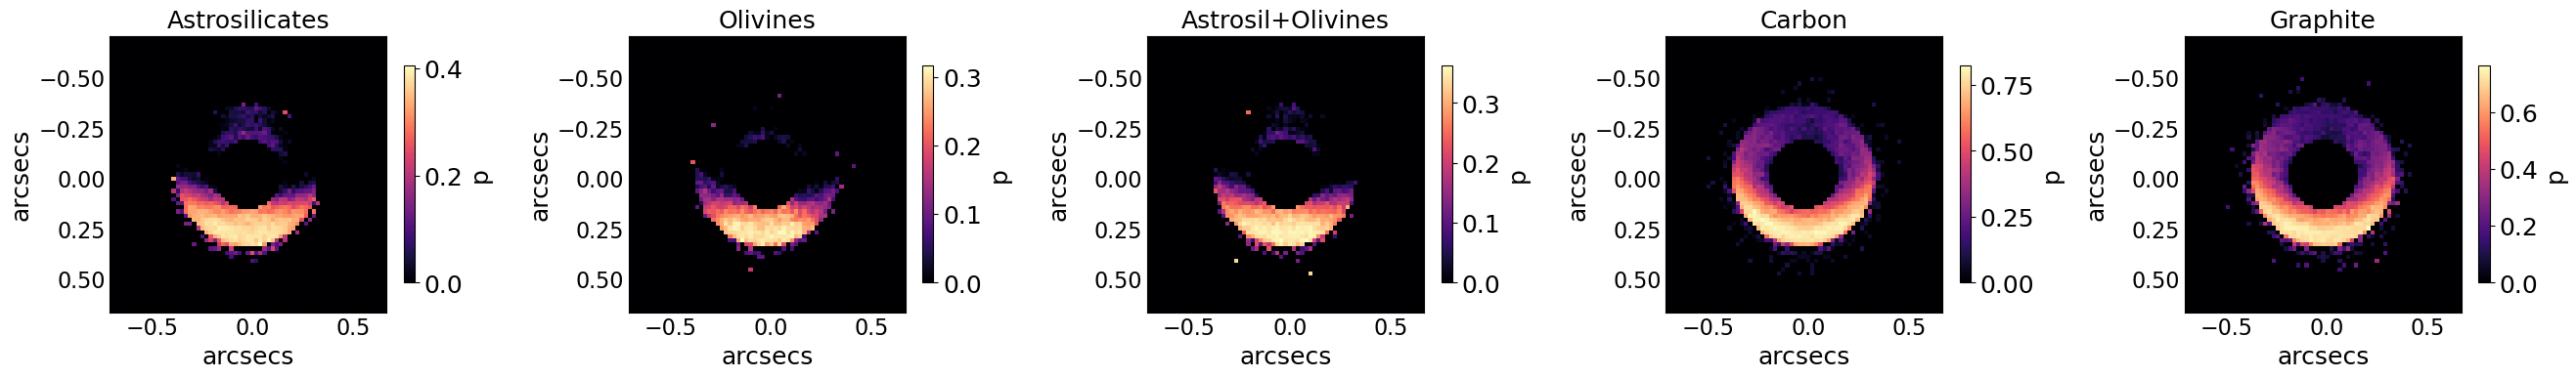

In [45]:
polarization_plot(dust_dir)

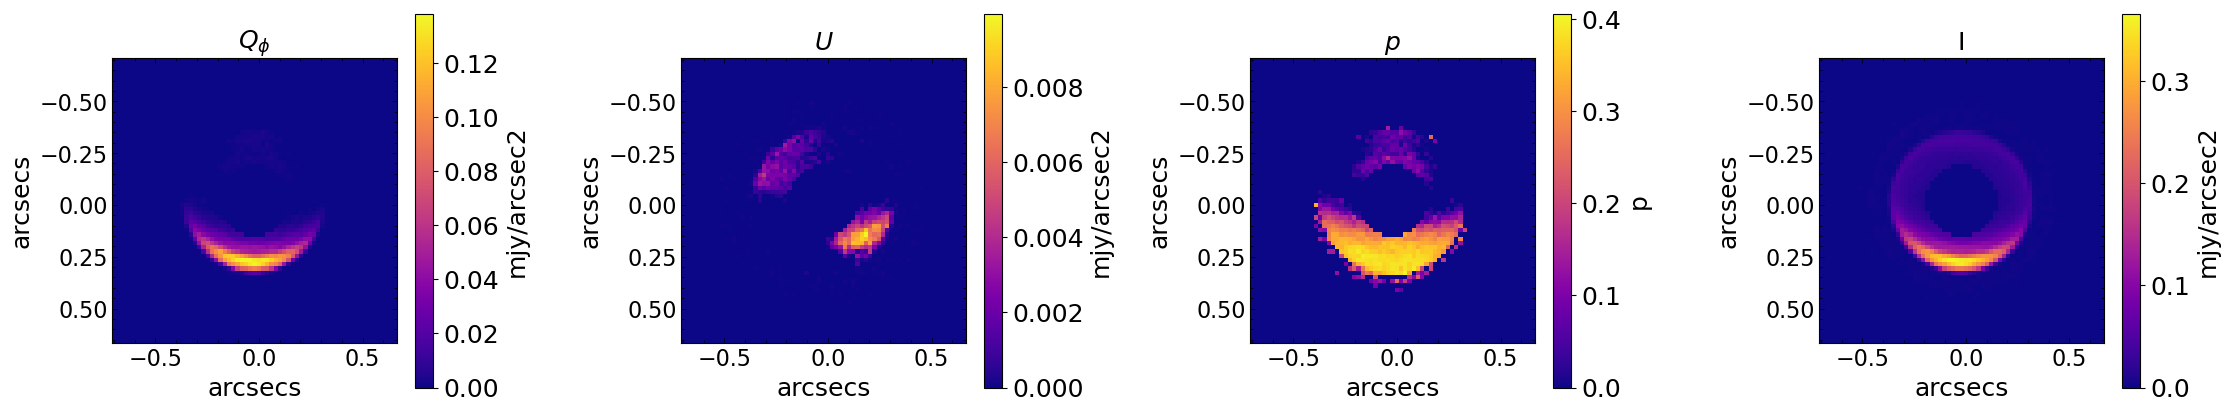

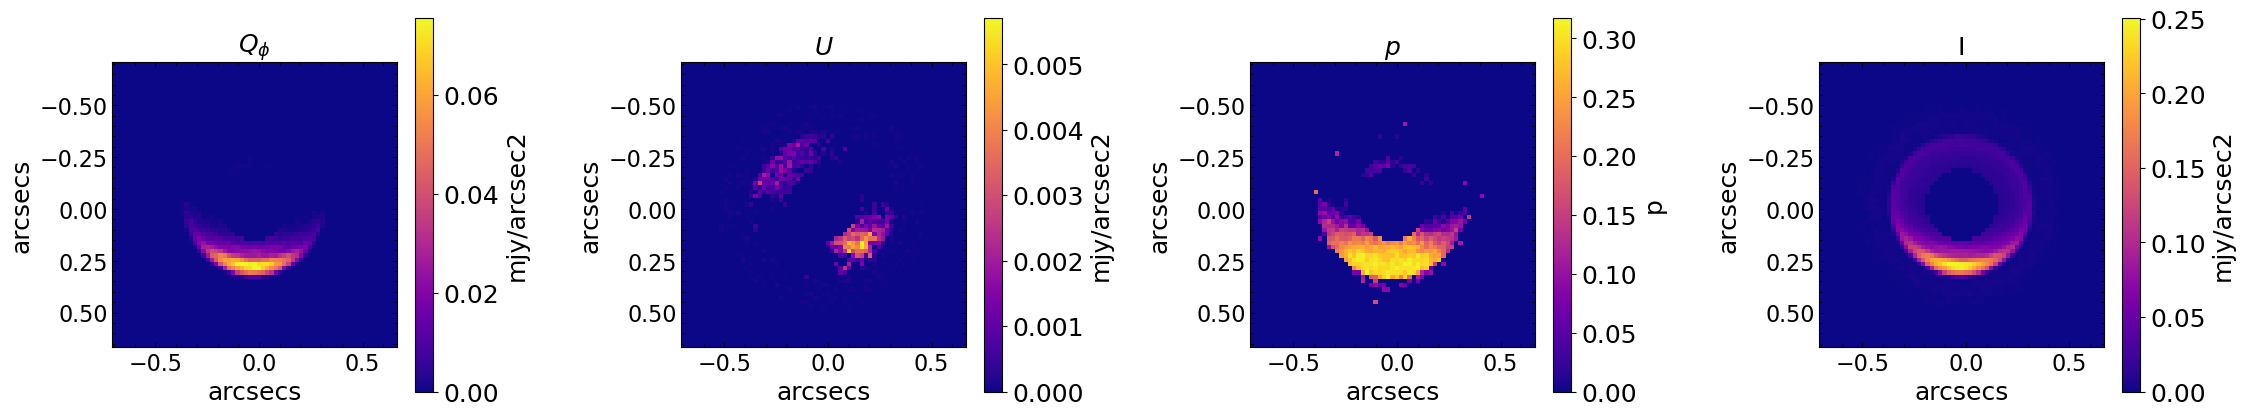

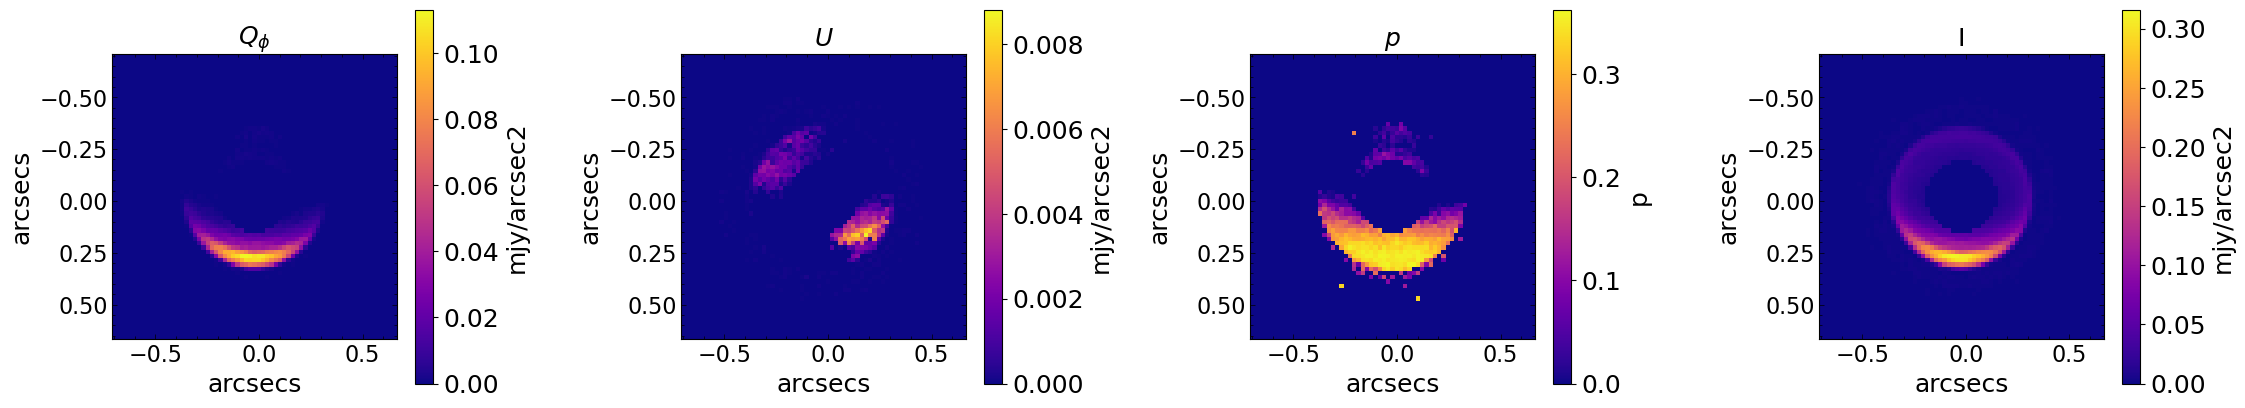

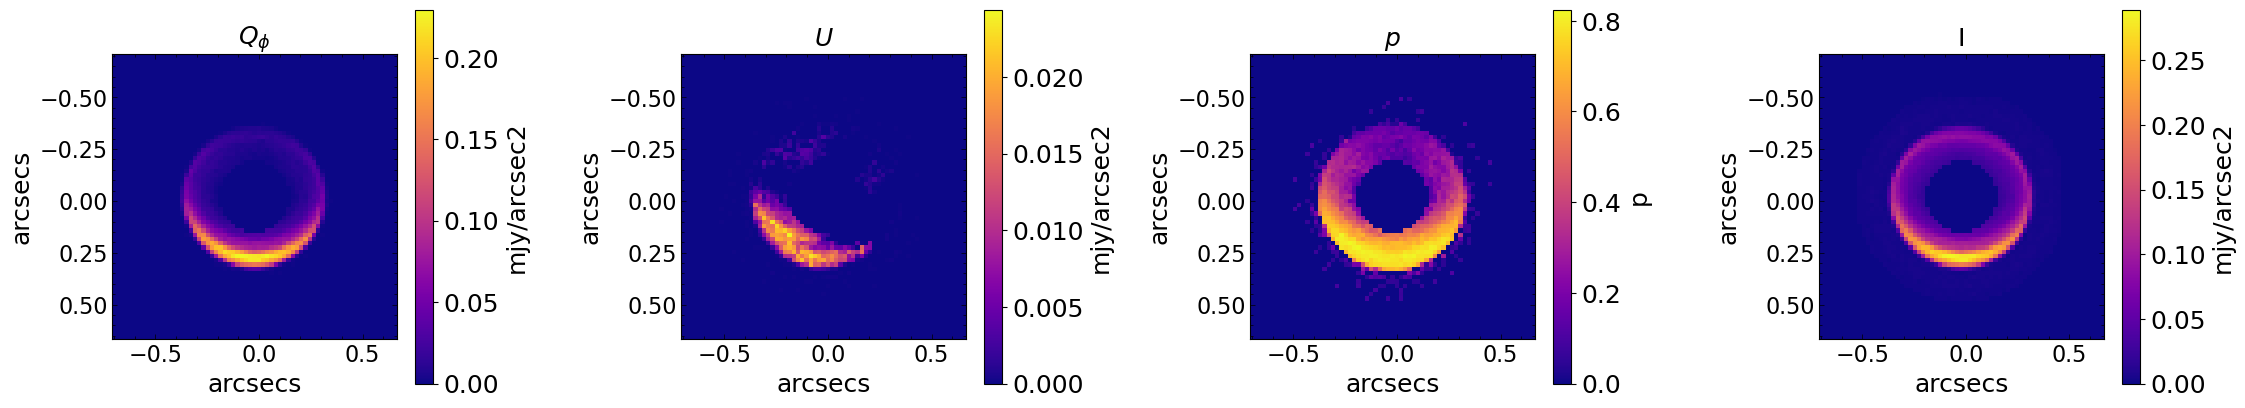

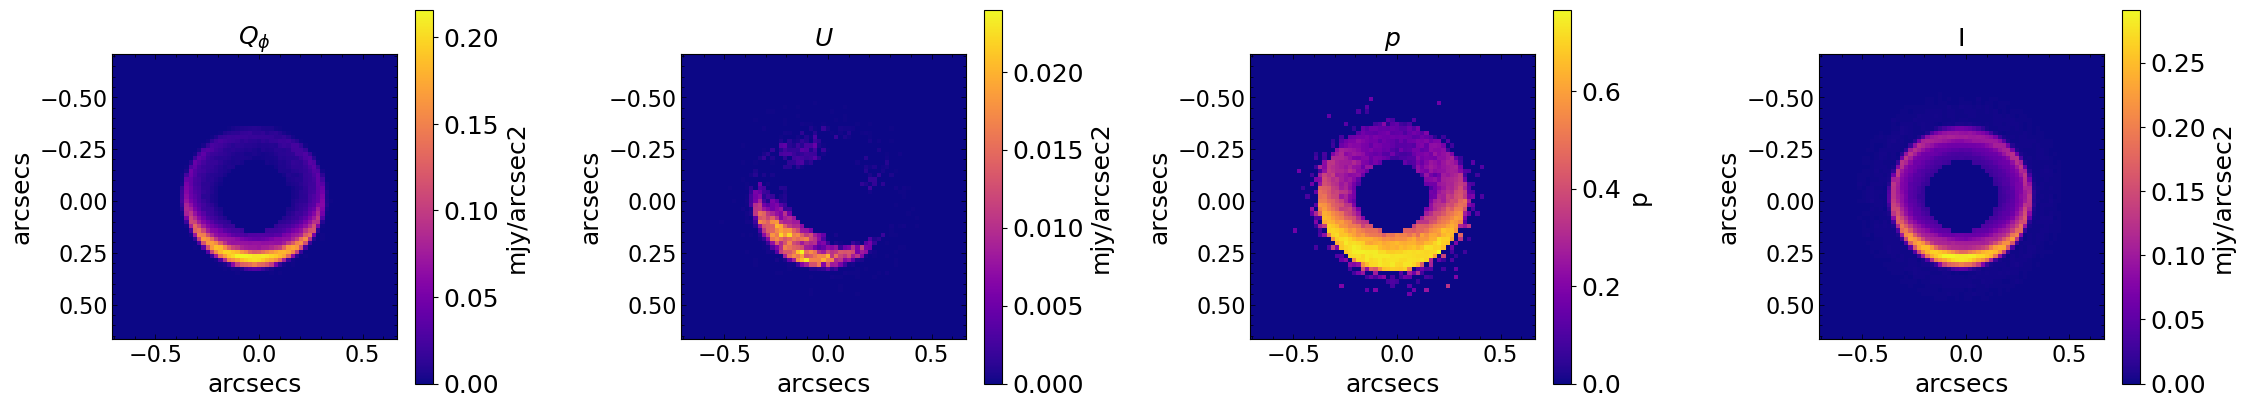

In [46]:
pol_out=polarization_est(dust_dir)

In [47]:
Q_lin=pol_out[0]
I_lin=pol_out[1]
p_frac=pol_out[2]
px=67
psf_scale=0.0208
xarc=(np.arange (-px+33, px-34, 1))*psf_scale

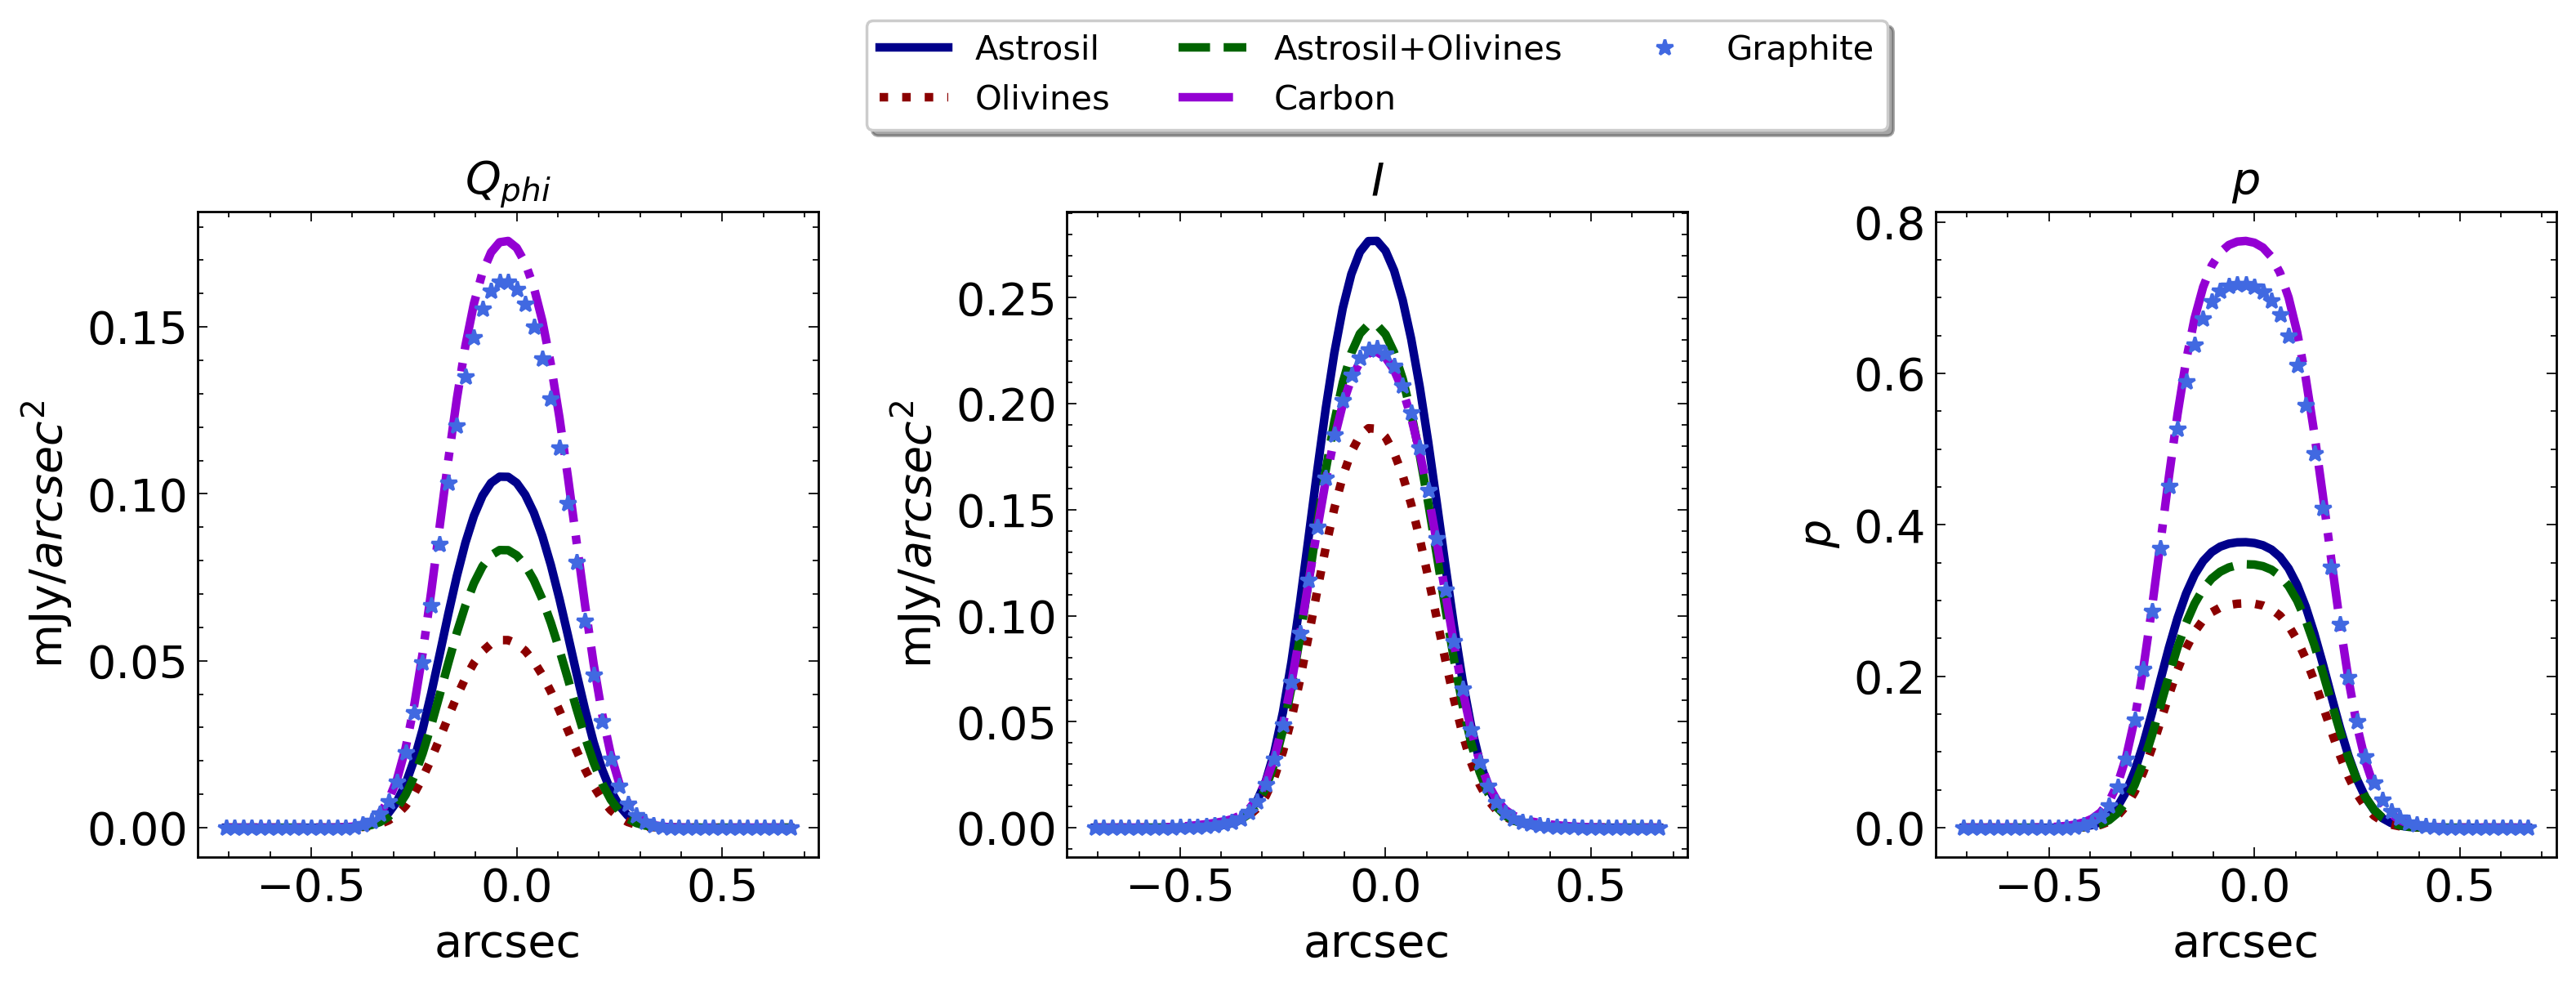

In [57]:
fig=plt.figure(figsize=(14,4),dpi=250)

ax1=fig.add_subplot(131)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', width=0.5, labelsize=16)
ax1.plot(xarc,gaussian_filter1d(Q_lin[0],3),ls='solid',color='darkblue',linewidth=3)
ax1.plot(xarc,gaussian_filter1d(Q_lin[1],3),ls='dotted',color='darkred',linewidth=3)
ax1.plot(xarc,gaussian_filter1d(Q_lin[2],3),ls='dashed',color='darkgreen',linewidth=3)
ax1.plot(xarc,gaussian_filter1d(Q_lin[3],3),ls='dashdot',color='darkviolet',linewidth=3)
ax1.plot(xarc,gaussian_filter1d(Q_lin[4],3),'*', color='royalblue',linewidth=3)
ax1.set_xlabel('arcsec', fontsize=16)
ax1.set_ylabel(u'mJy/$arcsec^2$',fontsize=16)
ax1.set_title(r'$Q_{phi}$',fontsize=16)


ax1=fig.add_subplot(132)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', width=0.5, labelsize=16)
ax1.plot(xarc,gaussian_filter1d(I_lin[0],3), ls='solid', color='darkblue',label='Astrosil',linewidth=3)
ax1.plot(xarc,gaussian_filter1d(I_lin[1],3), ls='dotted', color='darkred',label='Olivines',linewidth=3)
ax1.plot(xarc,gaussian_filter1d(I_lin[2],3), ls='dashed', color='darkgreen',label='Astrosil+Olivines',linewidth=3)
ax1.plot(xarc,gaussian_filter1d(I_lin[3],3), ls='dashdot', color='darkviolet',label='Carbon',linewidth=3)
ax1.plot(xarc,gaussian_filter1d(I_lin[4],3), '*', color='royalblue',label='Graphite',linewidth=3)
ax1.set_xlabel('arcsec',fontsize=16)
ax1.set_ylabel(u'mJy/$arcsec^2$',fontsize=16)
ax1.set_title('$I$',fontsize=16)
ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True,fontsize=12)


ax1=fig.add_subplot(133)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', width=0.5, labelsize=16)
ax1.plot(xarc,gaussian_filter1d(p_frac[0],3), ls='solid' ,color='darkblue', linewidth=3)
ax1.plot(xarc,gaussian_filter1d(p_frac[1],3), ls='dotted', color='darkred',linewidth=3,)
ax1.plot(xarc,gaussian_filter1d(p_frac[2],3), ls='dashed', color='darkgreen', linewidth=3)
ax1.plot(xarc,gaussian_filter1d(p_frac[3],3), ls='dashdot', color='darkviolet',linewidth=3)
ax1.plot(xarc,gaussian_filter1d(p_frac[4],3), '*', color='royalblue',linewidth=3)
ax1.set_xlabel('arcsec',fontsize=16)
ax1.set_ylabel('$p$',fontsize=16)
ax1.set_title('$p$',fontsize=16)
fig.subplots_adjust(hspace=0.1, wspace=0.4, top=0.9, right=0.95)
#fig.savefig(Main_dir+'polarization_dust_var.pdf', format='pdf', bbox_inches='tight')

In [211]:
np.max(p_frac[0])

0.18878578419758363

In [212]:
np.max(p_frac[1])

0.13565451979272855

In [213]:
np.max(p_frac[2])

0.15473602178671295

In [214]:
np.max(p_frac[3])

0.4365265857535563

In [215]:
np.max(p_frac[4])

0.39328898225957065